In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from qutip import *
import time
import pandas as pd

In [ ]:
plt.rcParams.update({'font.size': 18})

## Func Integrate

In [ ]:
def integrate(N, Bx, Bz, Jx, Jy, Jz, psi0, tlist, gamma, solver, M_basis, g2_size):

    si = qeye(2)
    sx = sigmax()
    sy = sigmay()
    sz = sigmaz()

    # Sn basis
    sn = [s.data[0,0]*sx+s.data[1,0]*sy+s.data[2,0]*sz for s in M_basis]

    sx_list = []
    sy_list = []
    sz_list = []
    sn_list = [None]*2
    snsn_list = []

    for n in range(N):
        op_list = []
        for m in range(N):
            op_list.append(si)
        
        op_list[n] = sx
        sx_list.append( tensor(op_list))

        op_list[n] = sy
        sy_list.append(tensor(op_list))

        op_list[n] = sz
        sz_list.append(tensor(op_list))

    for i,sni in enumerate(sn):
        sn_list[i] = []
        for n in range(N):
            op_list = []
            for m in range(N):
                op_list.append(si)
            
            op_list[n] = sni
            sn_list[i].append( tensor(op_list))

    for n in range(N-g2_size):
        op_list = []
        for m in range(N):
            op_list.append(si)
        op_list[n] = sn[0]
        op_list[n+g2_size] = sn[1]
        snsn_list.append(tensor(op_list))
        
    # construct the hamiltonian
    H = 0

    # energy splitting terms
    for n in range(N):
        H += - 0.5 * Bz[n] * sz_list[n]
        H += - 0.5 * Bx[n] * sx_list[n]
        
        
    # interaction terms
    for n in range(N-1):
        H += - 0.5 * Jx[n] * sx_list[n] * sx_list[n+1]
        H += - 0.5 * Jy[n] * sy_list[n] * sy_list[n+1]
        H += - 0.5 * Jz[n] * sz_list[n] * sz_list[n+1]

    # collapse operators
    c_op_list = []

    # spin dephasing
    for n in range(N):
        if gamma[n] > 0.0:
            c_op_list.append(np.sqrt(gamma[n]) * sz_list[n])
    
    # evolve and calculate expectation values
    if solver == "me":
        result1 = mesolve(H, psi0, tlist, c_op_list, sn_list[0])
        result2 = mesolve(H, psi0, tlist, c_op_list, sn_list[1])
        result3 = mesolve(H, psi0, tlist, c_op_list, snsn_list)
    elif solver == "mc":
        ntraj = 250 
        result = mcsolve(H, psi0, tlist, c_op_list, MB, ntraj)

    return (result1.expect,result2.expect,result3.expect)

## Main

### Normal chain

In [ ]:
start_time = time.time()
#
# set up the calculation
#
solver = "me"   # use the ode solver
#solver = "mc"   # use the monte-carlo solver

N = 4            # number of spins

Sbasis = Qobj([[1],[0],[0]]).unit()
Measure_basis = [ Sbasis, Sbasis] #sigmax, sigmay, sigmaz
g2_size = 1
# array of spin energy splittings and coupling strengths. here we use
# uniform parameters, but in general we don't have too
Bx = 0.0 * np.ones(N)
Bz = 0.0 * np.ones(N)
Jz = 1.0 * np.ones(N)
Jx = 0.0 * np.ones(N)
Jy = 0.0 * np.ones(N)
# dephasing rate
gamma = 0.00 * np.ones(N)

# intial state, first spin in state |1>, the rest in state |0>
psi_list = []
# psi_list.append((basis(2, 0) + basis(2, 1)).unit())
# psi_list.append(basis(2,0))
# psi_list.append(basis(2,0))
# psi_list.append(basis(2,0))
# psi_list.append(basis(2,0))
# psi_list.append(basis(2,0))

for n in range(N):
    # psi_list.append(basis(2,0)) #up |0>
    psi_list.append((basis(2, 0) + basis(2, 1)).unit()) # ix>
    # psi_list.append((basis(2, 0) + 1j*basis(2, 1)).unit()) # |y>
    
psi0 = tensor(psi_list)

tlist = np.linspace(0, 2*2*np.pi, 500)
# 
sn_expt,sn2_expt,sn3_expt = integrate(N, Bx, Bz, Jx, Jy, Jz, psi0, tlist, gamma, solver, Measure_basis, g2_size)
print("--- %0.4f seconds ---" % (time.time() - start_time))

--- 0.1801 seconds ---


(-0.1, 0.5)

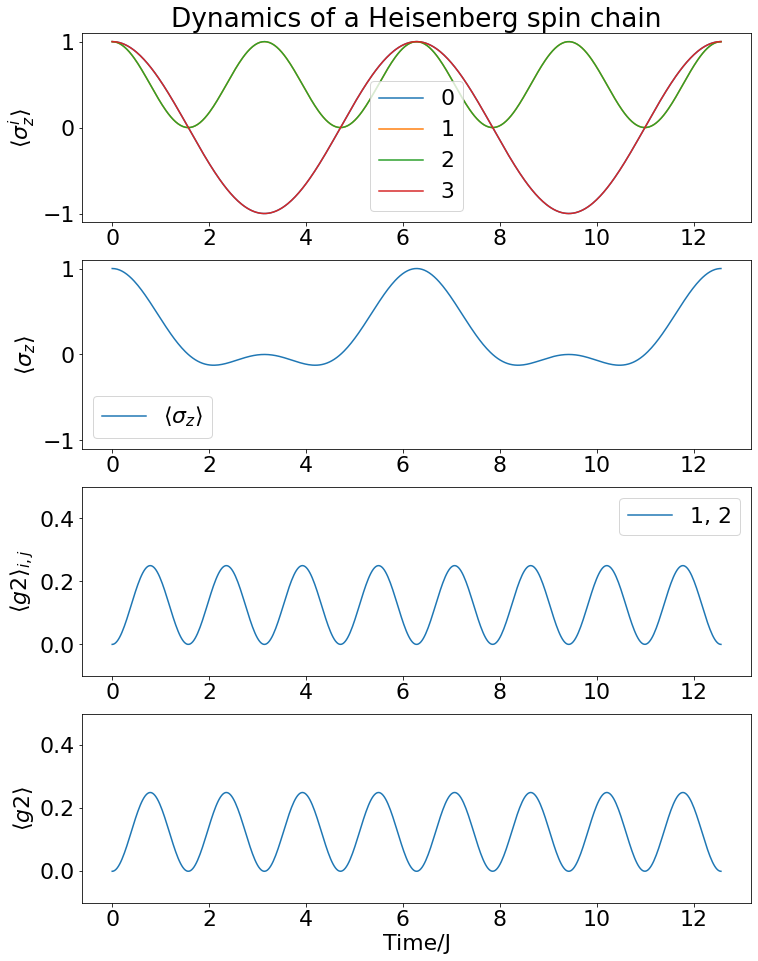

In [ ]:
ReEdge = 1
g2 = np.real(np.array(sn3_expt[ReEdge:N-1-ReEdge]))-np.real(np.array(sn_expt[ReEdge:N-1-ReEdge]))*np.real(np.array(sn2_expt[1+ReEdge:N-ReEdge]))
g2_real = g2
fig, (ax1,ax2,ax3,ax4) = plt.subplots(4,1,figsize=(12,16))

for n in range(len(sn_expt)):
    ax1.plot(tlist, np.real(sn_expt[n]), label=n)
for n in range(len(g2)):
    ax3.plot(tlist, g2[n],label='%d, %d'%(n+ReEdge,n+ReEdge+g2_size))
ax2.plot(tlist, np.real(np.array(sn_expt).mean(axis=0)),label=r'$\langle\sigma_z\rangle$')
ax4.plot(tlist, g2.mean(axis=0),label=r'average g2')

ax1.legend()
ax2.legend()
ax3.legend()
# ax4.legend()
ax4.set_xlabel('Time/J')
ax1.set_ylabel(r'$\langle\sigma_z^i\rangle$')
ax2.set_ylabel(r'$\langle\sigma_z\rangle$')
ax3.set_ylabel(r'$\langle g2\rangle_{i,j}$')
ax4.set_ylabel(r'$\langle g2\rangle$')

ax1.set_title('Dynamics of a Heisenberg spin chain');
ax1.set_ylim([-1.1,1.1])
ax2.set_ylim([-1.1,1.1])
ax3.set_ylim([-0.1,0.5])
ax4.set_ylim([-0.1,0.5])

### Fluctuation on $J_z$

In [1]:
start_time = time.time()
#
# set up the calculation
#
solver = "me"   # use the ode solver
#solver = "mc"   # use the monte-carlo solver

Nran = np.random.rand(10)
sn_expt = [None]*len(Nran)
sn2_expt = [None]*len(Nran)
sn3_expt = [None]*len(Nran)
RanTest = [None]*len(Nran)
for i,rani in enumerate(Nran):
    print('\r',i+1,end=" ")

    N = 4            # number of spins

    Sbasis = Qobj([[1],[0],[0]]).unit()
    Measure_basis = [ Sbasis, Sbasis] #sigmax, sigmay, sigmaz
    g2_size = 1
    # array of spin energy splittings and coupling strengths. here we use
    # uniform parameters, but in general we don't have too
    Bx = 0.0 * np.ones(N)
    Bz = 0.9 * np.ones(N)*(rani) 
    Jz = 1.0 * np.ones(N)
    Jx = 0.0 * np.ones(N)
    Jy = 0.0 * np.ones(N)

    RanTest[i] = Bz[0]
    # dephasing rate
    gamma = 0.00 * np.ones(N)

    # intial state, first spin in state |1>, the rest in state |0>
    psi_list = []
    # psi_list.append((basis(2, 0) + basis(2, 1)).unit())
    # psi_list.append(basis(2,0))
    # psi_list.append(basis(2,0))
    # psi_list.append(basis(2,0))
    # psi_list.append(basis(2,0))
    # psi_list.append(basis(2,0))

    for n in range(N):
        # psi_list.append(basis(2,0)) #up |0>
        psi_list.append((basis(2, 0) + basis(2, 1)).unit()) # ix>
        # psi_list.append((basis(2, 0) + 1j*basis(2, 1)).unit()) # |y>
        
    psi0 = tensor(psi_list)

    tlist = np.linspace(0, 2.0*2*np.pi, 500)
    # 
    sn_expt[i],sn2_expt[i],sn3_expt[i] = integrate(N, Bx, Bz, Jx, Jy, Jz, psi0, tlist, gamma, solver, Measure_basis, g2_size)
print("--- %0.4f seconds ---" % (time.time() - start_time))

NameError: name 'time' is not defined

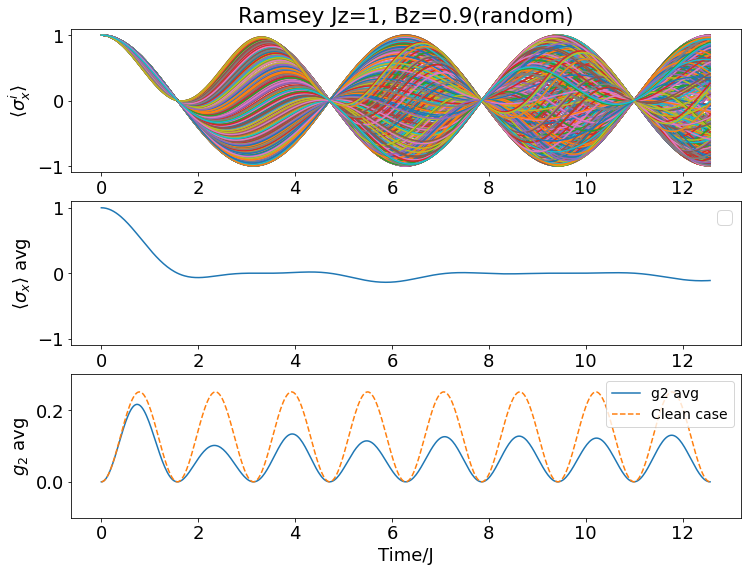

In [ ]:
g2=[None]*len(Nran)
for i in range(len(Nran)):
    ReEdge = 1
    g2[i] = np.real(np.array(sn3_expt[i][ReEdge:N-1-ReEdge]))-np.real(np.array(sn_expt[i][ReEdge:N-1-ReEdge]))*np.real(np.array(sn2_expt[i][1+ReEdge:N-ReEdge]))

fig, (ax1,ax2,ax3) = plt.subplots(3,1,figsize=(12,9))

# for n in range(N):
#     ax1.plot(tlist, np.real(np.array(sn_expt).mean(axis=0))[n], label=n)

for n in range(len(Nran)):
    ax1.plot(tlist, np.real(sn_expt[n][0]))
ax2.plot(tlist, np.real(np.array(sn_expt).mean(axis=0)).mean(axis=0))
ax3.plot(tlist, np.real(np.array(g2).mean(axis=0)).mean(axis=0), label='g2 avg')
ax3.plot(tlist,g2_real[0],'--', label='Clean case')

ax3.legend(fontsize=14)
ax1.set_title('Ramsey Jz=1, Bz=0.9(random)')
ax3.set_xlabel('Time/J')
ax1.set_ylabel(r'$\langle\sigma_x^i\rangle$')
ax2.set_ylabel(r'$\langle\sigma_x\rangle$ avg')
ax3.set_ylabel(r'$g_2$ avg')
ax1.set_ylim([-1.1,1.1])
ax2.set_ylim([-1.1,1.1])
ax3.set_ylim([-0.1,0.3])

# fig.savefig('Outputs/'+'Ramsey Jz=1, Bz=0.9(random).png', dpi=300)

Text(0.5, 0, 'phase *2pi')

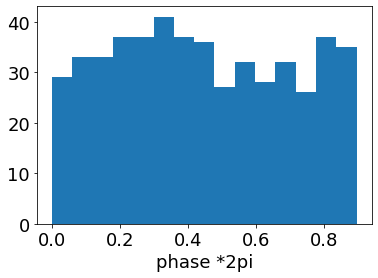

In [ ]:
Forplot = [i%(2*np.pi) for i in RanTest]
y=[0]*len(Forplot)
# plt.plot(Forplot,y,'.')
plt.hist(Forplot, bins=15)
plt.xlabel('phase *2pi')


### Random measurement $<\sigma_n>$

In [ ]:
def plot(sn_expt,sn2_expt,sn3_expt,Nind):
    g2=[None]*len(sn_expt)
    N = len(sn_expt[0])
    for i in range(len(sn_expt)):
        ReEdge = 1
        g2[i] = np.real(np.array(sn3_expt[i][ReEdge:N-1-ReEdge]))-np.real(np.array(sn_expt[i][ReEdge:N-1-ReEdge]))*np.real(np.array(sn2_expt[i][1+ReEdge:N-ReEdge]))

    

    ax1.plot(tlist, np.real(np.array(sn_expt).mean(axis=0)).mean(axis=0), label='%d avg'%Nind)
    ax2.plot(tlist, np.real(np.array(g2).mean(axis=0)).mean(axis=0), label='%d g2 avg'%Nind)
    ax1.legend()
    ax2.legend()
    ax1.set_xlabel('Time/J')
    ax1.set_ylabel(r'$\langle\sigma_z\rangle$ avg')
    ax2.set_ylabel(r'$g_2$ avg')
    ax1.set_ylim([-1.1,1.1])
    ax2.set_ylim([-0.1,0.3])
    plt.draw()

 300--- 54.3287 seconds ---


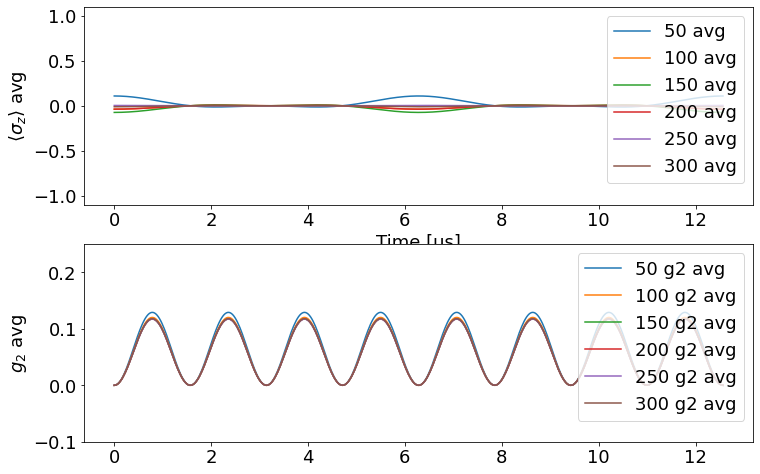

In [ ]:
start_time = time.time()
#
# set up the calculation
#
solver = "me"   # use the ode solver
#solver = "mc"   # use the monte-carlo solver
fig, (ax1,ax2) = plt.subplots(2,1,figsize=(12,8))

Nran = 300
sn_expt = [None]*Nran
sn2_expt = [None]*Nran
sn3_expt = [None]*Nran
RanTest = [None]*Nran
for i in range(Nran):
    print('\r',i+1,end="")

    N = 4            # number of spins

    # Sbasis = rand_ket(3) #Qobj([[1],[0],[0]]).unit()

    # random
    dom = 2*np.pi*np.random.rand()
    Sbasis = Qobj([[np.cos(dom)],[np.sin(dom)],[0]]).unit()
    RanTest[i] = Sbasis
    Measure_basis = [ Sbasis, Sbasis] #sigmax, sigmay, sigmaz
    g2_size = 1
    # array of spin energy splittings and coupling strengths. here we use
    # uniform parameters, but in general we don't have too
    Bx = 0.0 * np.ones(N)
    Bz = 0.0 * np.ones(N)
    Jz = 1.0 * np.ones(N)
    Jx = 0.0 * np.ones(N)
    Jy = 0.0 * np.ones(N)
    # dephasing rate
    gamma = 0.00 * np.ones(N)

    # intial state, first spin in state |1>, the rest in state |0>
    psi_list = []
    # psi_list.append((basis(2, 0) + basis(2, 1)).unit())
    # psi_list.append(basis(2,0))
    # psi_list.append(basis(2,0))
    # psi_list.append(basis(2,0))
    # psi_list.append(basis(2,0))
    # psi_list.append(basis(2,0))

    for n in range(N):
        # psi_list.append(basis(2,0)) #up |0>
        psi_list.append((basis(2, 0) + basis(2, 1)).unit()) # ix>
        # psi_list.append((basis(2, 0) + 1j*basis(2, 1)).unit()) # |y>
        
    psi0 = tensor(psi_list)

    tlist = np.linspace(0, 2*2*np.pi, 500)
    # 
    sn_expt[i],sn2_expt[i],sn3_expt[i] = integrate(N, Bx, Bz, Jx, Jy, Jz, psi0, tlist, gamma, solver, Measure_basis, g2_size)
    if (i+1)%50 == 0: 
        plot(sn_expt[0:i],sn2_expt[0:i],sn3_expt[0:i],i+1)

print("--- %0.4f seconds ---" % (time.time() - start_time))

/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel_launcher.py:4: ComplexWarning: Casting complex values to real discards the imaginary part
  after removing the cwd from sys.path.
/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel_launcher.py:5: ComplexWarning: Casting complex values to real discards the imaginary part
  """
/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel_launcher.py:6: ComplexWarning: Casting complex values to real discards the imaginary part
  


Text(0.5, 0, 'phase *2pi')

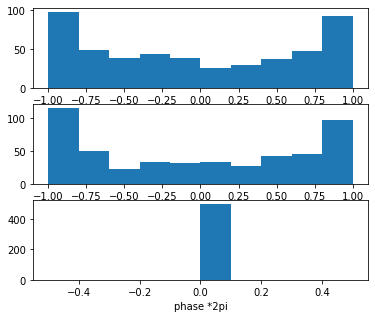

In [ ]:
# test random
fig, (ax1,ax2,ax3) = plt.subplots(3,1,figsize=(6,5))

Forplotx = [float(i.data[0,0]) for i in RanTest]
Forploty = [float(i.data[1,0]) for i in RanTest]
Forplotz = [float(i.data[2,0]) for i in RanTest]

# plt.plot(Forplot,y,'.')
ax1.hist(Forplotx, bins=10)
ax2.hist(Forploty, bins=10)
ax3.hist(Forplotz, bins=10)
plt.xlabel('phase *2pi')


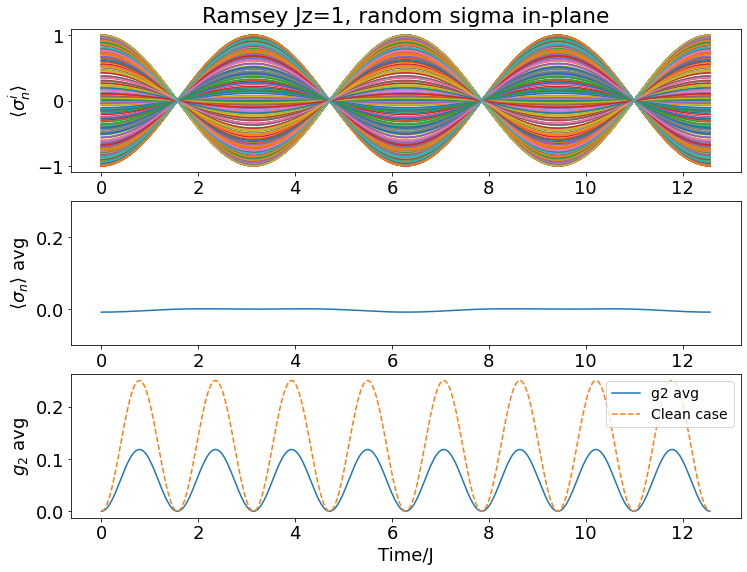

In [ ]:
g2=[None]*Nran
for i in range(Nran):
    ReEdge = 1
    g2[i] = np.real(np.array(sn3_expt[i][ReEdge:N-1-ReEdge]))-np.real(np.array(sn_expt[i][ReEdge:N-1-ReEdge]))*np.real(np.array(sn2_expt[i][1+ReEdge:N-ReEdge]))

fig, (ax1,ax2,ax3) = plt.subplots(3,1,figsize=(12,9))

# for n in range(N):
#     ax1.plot(tlist, np.real(np.array(sn_expt).mean(axis=0))[n], label=n)

for n in range(Nran):
    ax1.plot(tlist, np.real(sn_expt[n][0]))
ax2.plot(tlist, np.real(np.array(sn_expt).mean(axis=0)).mean(axis=0))
ax3.plot(tlist, np.real(np.array(g2).mean(axis=0)).mean(axis=0), label='g2 avg')
ax3.plot(tlist,g2_real[0],'--', label='Clean case')

ax3.legend(fontsize=14)
ax1.set_title('Ramsey Jz=1, random sigma in-plane')
ax3.set_xlabel('Time/J')
ax1.set_ylabel(r'$\langle\sigma_n^i\rangle$')
ax2.set_ylabel(r'$\langle\sigma_n\rangle$ avg')
ax3.set_ylabel(r'$g_2$ avg')
ax1.set_ylim([-1.1,1.1])
ax2.set_ylim([-1.1,1.1])
ax2.set_ylim([-0.1,0.3])

# fig.savefig('Outputs/'+'Ramsey Jz=1, random sigma in-plane.png', dpi=300)

Text(0.5, 0, 'phase *2pi')

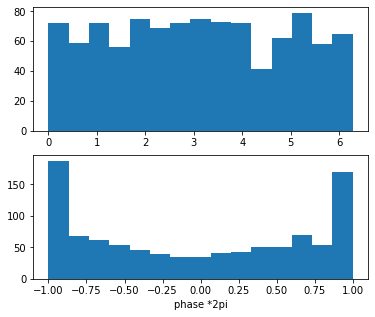

In [ ]:
dom = 2*np.pi*np.random.rand(1000)
cos = np.cos(dom)
fig, (ax1,ax2) = plt.subplots(2,1,figsize=(6,5))
# plt.plot(Forplot,y,'.')
ax1.hist(dom, bins=15)
ax2.hist(cos, bins=15)
plt.xlabel('phase *2pi')

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=ad574db9-57f6-4918-b977-e02cef63b094' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>